In [1]:
import platform

os_name = platform.system()
os_name

'Windows'

In [2]:
walkthrough_example_path = r"original_scans/NikonS60/22 B 07247 D1.ndpi"
wsi_path = "D:/" + walkthrough_example_path if os_name == "Windows" else "mnt/d" + walkthrough_example_path
tile_size = 360
output_dir = "_jupyter_tests/"
n = 2048
wsi_path

'D:/original_scans/NikonS60/22 B 07247 D1.ndpi'

In [3]:
import os
import openslide

slide_id, _ = os.path.splitext(os.path.basename(wsi_path))
wsi = openslide.open_slide(wsi_path)

In [116]:
QC_DIR = output_dir
TILE_DIR = os.path.join(output_dir, "train")
slide_dir = os.path.join(TILE_DIR, slide_id)

os.makedirs(QC_DIR, exist_ok=True)
os.makedirs(TILE_DIR, exist_ok=True)
os.makedirs(slide_dir, exist_ok=True)

In [6]:
def write_report_block(title, rows, report_file : None):
    header = f"\n========== {title} ==========\n"
    columns = f"{'Phase':<35} {'Value':<40}\n"
    line = "-" * 80 + "\n"

    if report_file is not None:
        report_file.write(header)
        report_file.write(columns)
        report_file.write(line)

    print(header.strip())
    print(columns.strip())
    print(line.strip())

    for phase, value in rows:
        value_str = str(value)  # <-- FIX CRITICO
        row = f"{phase:<35} {value_str:<40}\n"
        if report_file is not None:
            report_file.write(row)
        print(row.strip())

# 0. WSI Info

In [7]:
write_report_block("WSI SUMMARY", [
        ("Slide ID", slide_id),("Slide Path",wsi_path),
        ("Dimensions", str(wsi.dimensions)),
        ("Levels", str(wsi.level_downsamples)),
        ("Level dimensions", str(wsi.level_dimensions)),
        ("Objective power", str(wsi.properties.get(openslide.PROPERTY_NAME_OBJECTIVE_POWER, 'unknown'))),
        ("MPP", f"{wsi.properties.get(openslide.PROPERTY_NAME_MPP_X, 'unknown')} x {wsi.properties.get(openslide.PROPERTY_NAME_MPP_Y, 'unknown')}")
    ], None)

========== WSI SUMMARY ==========
Phase                               Value
--------------------------------------------------------------------------------
Slide ID                            22 B 07247 D1
Slide Path                          D:/original_scans/NikonS60/22 B 07247 D1.ndpi
Dimensions                          (161280, 96768)
Levels                              (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0)
Level dimensions                    ((161280, 96768), (80640, 48384), (40320, 24192), (20160, 12096), (10080, 6048), (5040, 3024), (2520, 1512), (1260, 756), (630, 378), (315, 189))
Objective power                     40
MPP                                 0.22101401228837908 x 0.22101401228837908


# 1.1 Tissue Masking

In [8]:
seg_level = wsi.get_best_level_for_downsample(64)
seg_level

6

In [9]:
wsi.level_downsamples[6]

64.0

In [10]:
wsi.level_dimensions[6]

(2520, 1512)

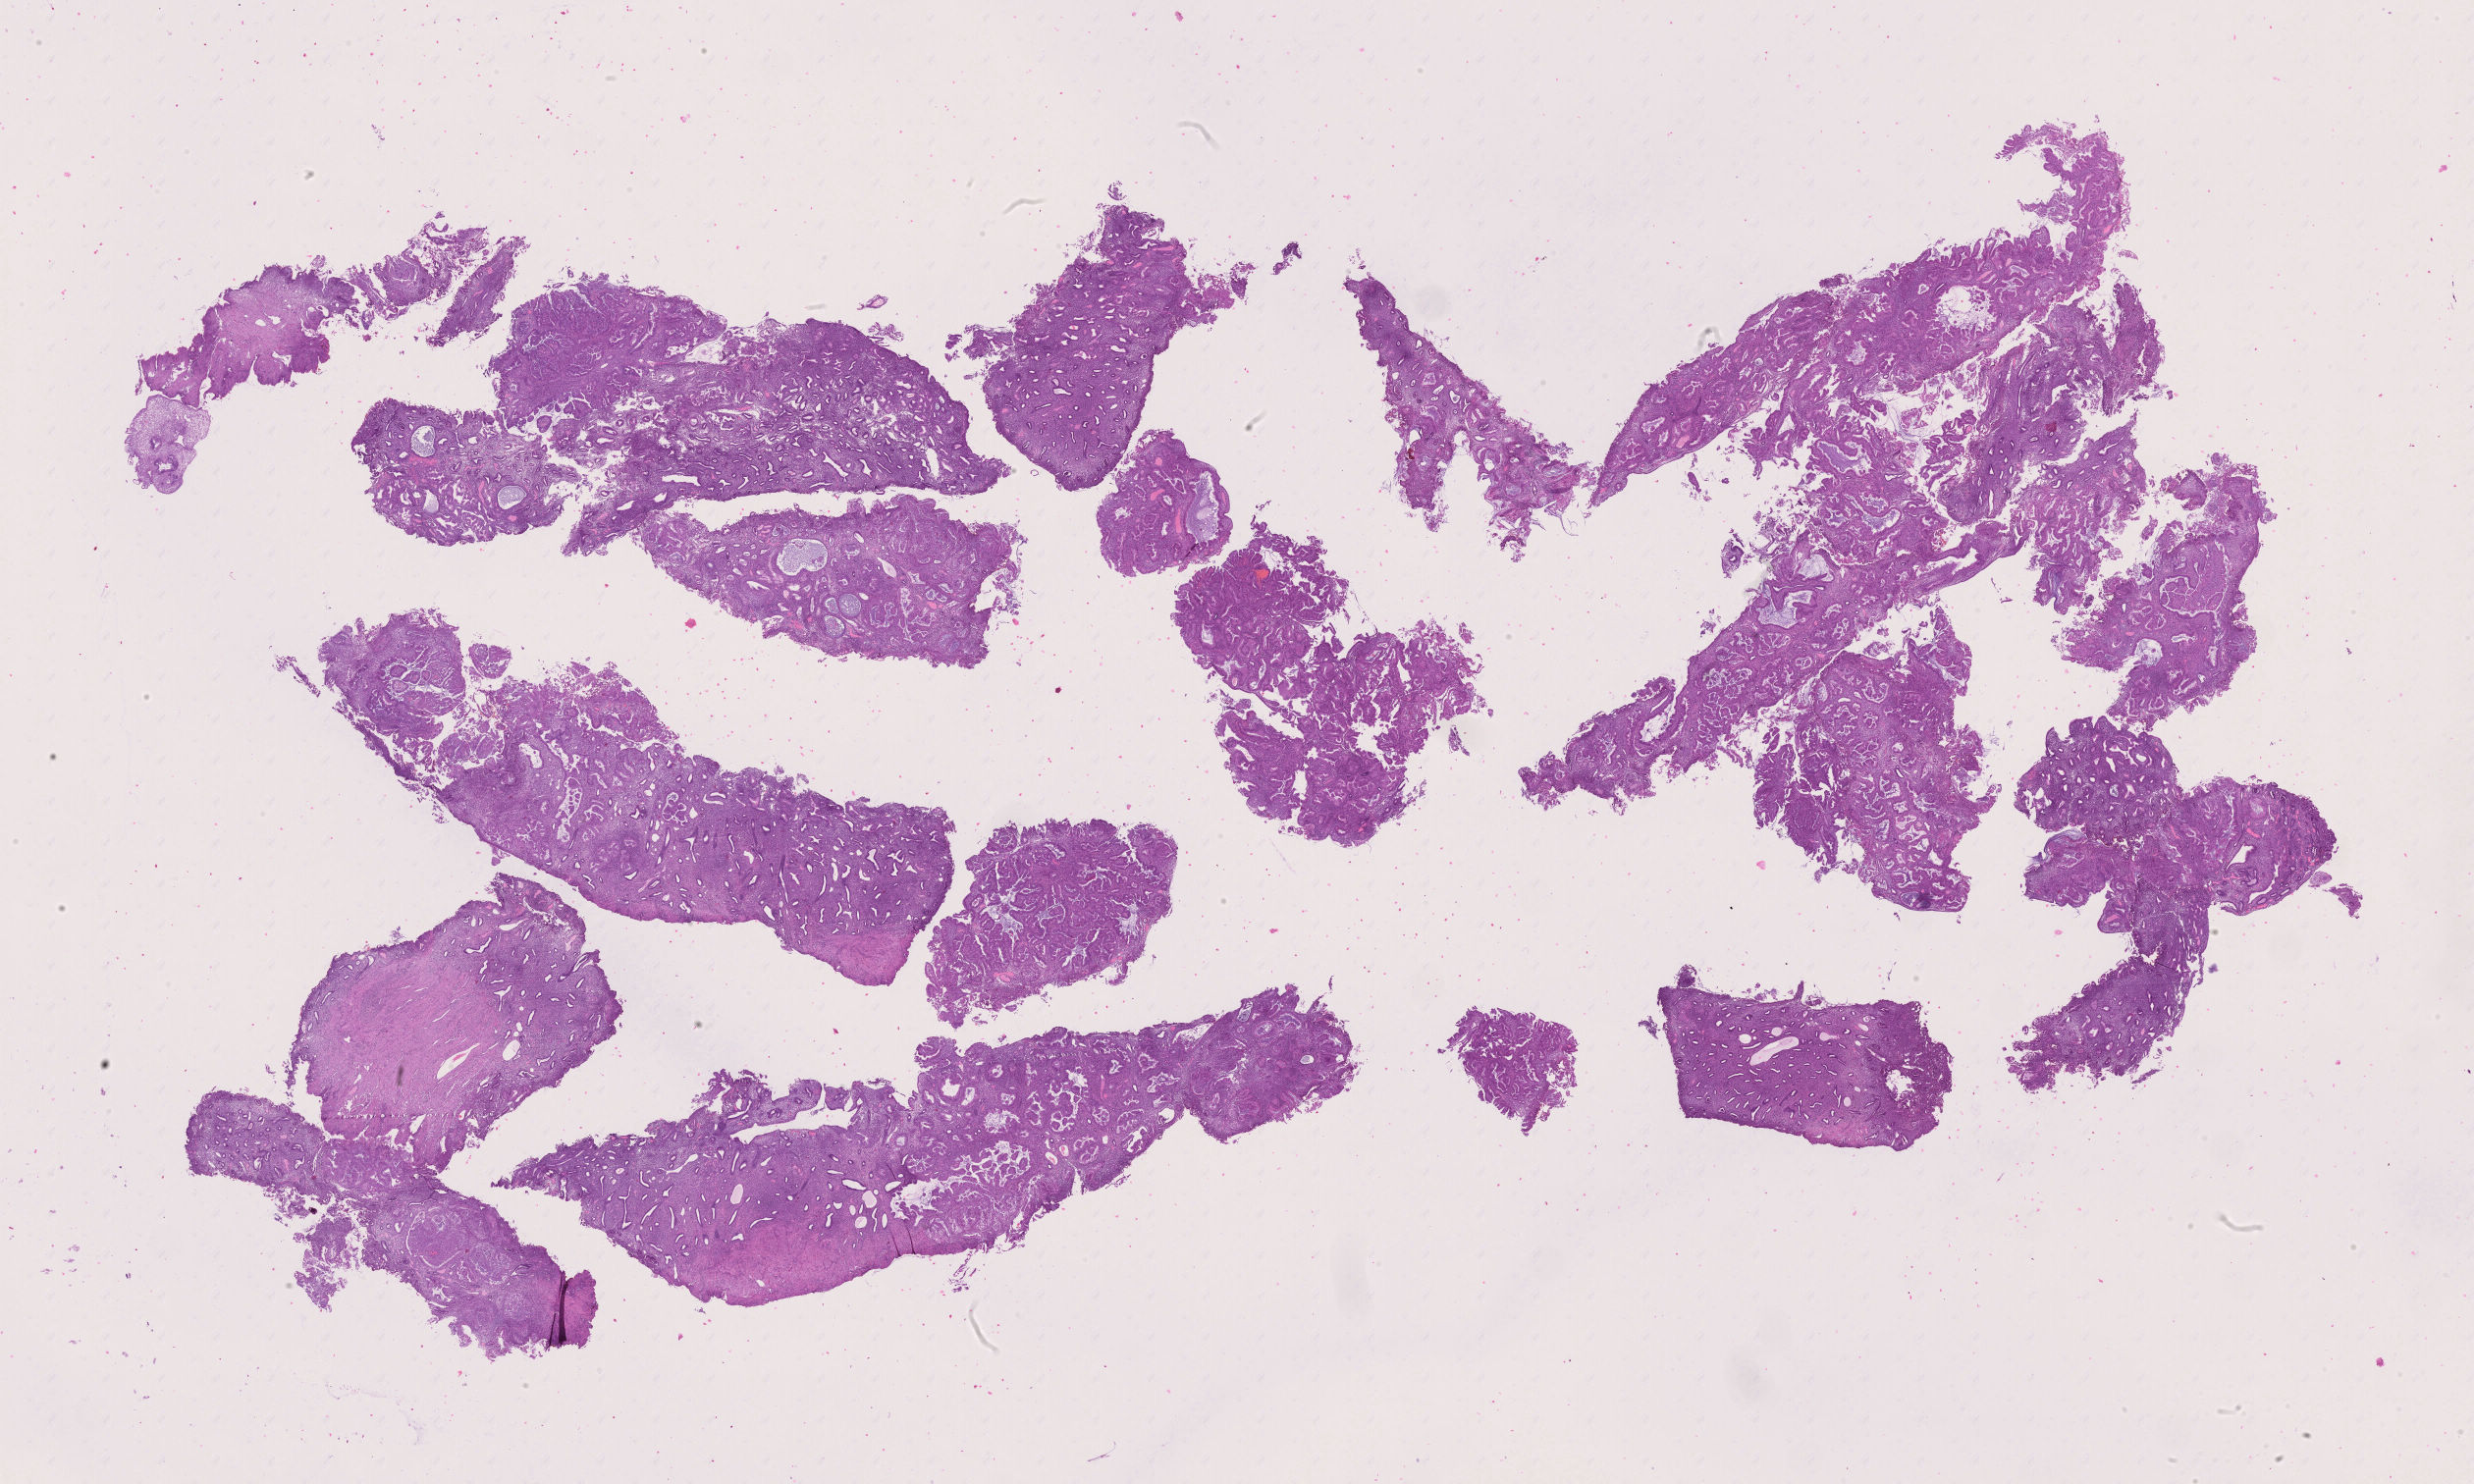

In [11]:
img = wsi.read_region((0, 0), 6, wsi.level_dimensions[6])
img

In [101]:
import numpy as np
import cv2
from shapely.affinity import scale
from shapely.geometry import Polygon

def _segment_tissue(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mthresh = 7
    img_med = cv2.medianBlur(img_hsv[:, :, 1], mthresh)
    _, img_prepped = cv2.threshold(img_med, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)

    close = 4
    kernel = np.ones((close, close), np.uint8)
    img_prepped = cv2.morphologyEx(img_prepped, cv2.MORPH_CLOSE, kernel)

    # Find and filter contours
    contours, hierarchy = cv2.findContours(
        img_prepped, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE
    )
    return contours, hierarchy

def _construct_polygon(foreground_contours, hole_contours, min_area):
    from shapely.ops import unary_union
    polys = []
    for foreground, holes in zip(foreground_contours, hole_contours):
        # We remove all contours that consist of fewer than 3 points, as these won't work with the Polygon constructor.
        if len(foreground) < 3:
            continue

        # remove redundant dimensions from the contour and convert to Shapely Polygon
        poly = Polygon(np.squeeze(foreground))

        # discard all polygons that are considered too small
        if poly.area < min_area:
            continue

        if not poly.is_valid:
            # This is likely becausee the polygon is self-touching or self-crossing.
            # Try and 'correct' the polygon using the zero-length buffer() trick.
            # See https://shapely.readthedocs.io/en/stable/manual.html#object.buffer
            poly = poly.buffer(0)

        # Punch the holes in the polygon
        for hole_contour in holes:
            if len(hole_contour) < 3:
                continue

            hole = Polygon(np.squeeze(hole_contour))

            if not hole.is_valid:
                continue

            # ignore all very small holes
            if hole.area < min_area:
                continue

            poly = poly.difference(hole)

        polys.append(poly)

    if len(polys) == 0:
        raise Exception("Raw tissue mask consists of 0 polygons")

    # If we have multiple polygons, we merge any overlap between them using unary_union().
    # This will result in a Polygon or MultiPolygon with most tissue masks.
    return unary_union(polys)

def _detect_foreground(contours, hierarchy):
    hierarchy = np.squeeze(hierarchy, axis=(0,))[:, 2:]

    # find foreground contours (parent == -1)
    hierarchy_1 = np.flatnonzero(hierarchy[:, 1] == -1)
    foreground_contours = [contours[cont_idx] for cont_idx in hierarchy_1]

    all_holes = []
    for cont_idx in hierarchy_1:
        all_holes.append(np.flatnonzero(hierarchy[:, 1] == cont_idx))

    hole_contours = []
    for hole_ids in all_holes:
        holes = [contours[idx] for idx in hole_ids]
        hole_contours.append(holes)

    return foreground_contours, hole_contours

def create_tissue_mask(wsi, seg_level, report_file=None):

    rows = []

    # --- STEP 1: dimensioni livello ---
    level_dims = wsi.level_dimensions[seg_level]
    level_area = level_dims[0] * level_dims[1]

    rows.append(("Segmentation level", seg_level))
    rows.append(("Level dimensions", level_dims))
    rows.append(("Level area (pixels)", level_area))

    write_report_block("WSI LEVEL INFO", rows, report_file)

    # --- STEP 2: lettura immagine ---
    img = np.array(wsi.read_region((0, 0), seg_level, level_dims))

    rows = []
    rows.append(("Image shape", img.shape))
    rows.append(("Image dtype", img.dtype))

    write_report_block("IMAGE ACQUISITION", rows, report_file)

    # --- STEP 3: min_area ---
    min_area = level_area / 500

    rows = []
    rows.append(("Min polygon area", min_area))

    write_report_block("AREA THRESHOLD", rows, report_file)

    # --- STEP 4: segmentazione ---
    contours, hierarchy = _segment_tissue(img)

    rows = []
    rows.append(("Total contours found", len(contours)))
    rows.append(("Hierarchy shape", hierarchy.shape))

    write_report_block("SEGMENTATION", rows, report_file)

    # --- STEP 5: foreground / holes ---
    foreground_contours, hole_contours = _detect_foreground(contours, hierarchy)

    rows = []
    rows.append(("Foreground contours", len(foreground_contours)))
    rows.append(("Hole groups", len(hole_contours)))

    holes_count = sum(len(h) for h in hole_contours)
    rows.append(("Total hole contours", holes_count))

    write_report_block("FOREGROUND & HOLES", rows, report_file)

    # --- STEP 6: costruzione poligoni ---
    tissue_mask = _construct_polygon(foreground_contours, hole_contours, min_area)

    rows = []
    rows.append(("Tissue mask type", type(tissue_mask).__name__))
    rows.append(("Tissue mask area", tissue_mask.area))
    rows.append(("Is valid polygon", tissue_mask.is_valid))

    write_report_block("POLYGON CONSTRUCTION", rows, report_file)

    # --- STEP 7: scaling ---
    scale_factor = wsi.level_downsamples[seg_level]

    tissue_mask_scaled = scale(
        tissue_mask,
        xfact=scale_factor,
        yfact=scale_factor,
        zfact=1.0,
        origin=(0, 0)
    )

    rows = []
    rows.append(("Scale factor", scale_factor))
    rows.append(("Scaled mask area", tissue_mask_scaled.area))

    write_report_block("SCALING TO LEVEL 0", rows, report_file)

    return tissue_mask_scaled


In [99]:
tissue_mask_scaled = create_tissue_mask(wsi, seg_level=wsi.get_best_level_for_downsample(64))

In [100]:
type(tissue_mask_scaled)

shapely.geometry.multipolygon.MultiPolygon

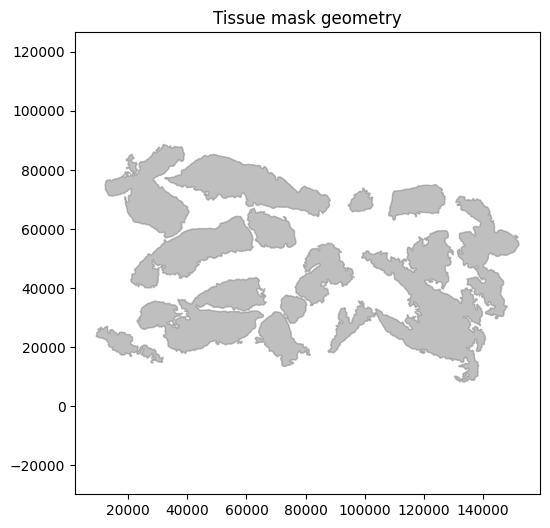

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))

if tissue_mask_scaled.geom_type == "MultiPolygon":
    for poly in tissue_mask_scaled.geoms:
        x, y = poly.exterior.xy
        plt.fill(x, y, color='gray', alpha=0.5)  # <- colore fisso
else:
    x, y = tissue_mask_scaled.exterior.xy
    plt.fill(x, y, color='gray', alpha=0.5)  # <- colore fisso

plt.axis("equal")
plt.title("Tissue mask geometry")
plt.show()

# 1.2 Tiling

In [102]:
def _generate_tiles(
    tile_width_pix, tile_height_pix, img_width, img_height, offsets=[(0, 0)]
):
    # Generate tiles covering the entire image.
    # Provide an offset (x,y) to create a stride-like overlap effect.
    # Add an additional tile size to the range stop to prevent tiles being cut off at the edges.
    range_stop_width = int(np.ceil(img_width + tile_width_pix))
    range_stop_height = int(np.ceil(img_height + tile_height_pix))

    rects = []
    for xmin, ymin in offsets:
        cols = range(int(np.floor(xmin)), range_stop_width, tile_width_pix)
        rows = range(int(np.floor(ymin)), range_stop_height, tile_height_pix)
        for x in cols:
            for y in rows:
                rect = Polygon(
                    [
                        (x, y),
                        (x + tile_width_pix, y),
                        (x + tile_width_pix, y - tile_height_pix),
                        (x, y - tile_height_pix),
                    ]
                )
                rects.append(rect)
    return rects

def create_tissue_tiles(
    wsi, tissue_mask_scaled, tile_size_microns, offsets_micron=None
):

    print(f"tile size is {tile_size_microns} um")

    # Compute the tile size in pixels from the desired tile size in microns and the image resolution
    assert (
        openslide.PROPERTY_NAME_MPP_X in wsi.properties
    ), "microns per pixel along X-dimension not available"
    assert (
        openslide.PROPERTY_NAME_MPP_Y in wsi.properties
    ), "microns per pixel along Y-dimension not available"

    mpp_x = float(wsi.properties[openslide.PROPERTY_NAME_MPP_X])
    mpp_y = float(wsi.properties[openslide.PROPERTY_NAME_MPP_Y])
    mpp_scale_factor = min(mpp_x, mpp_y)
    if mpp_x != mpp_y:
        print(
            f"mpp_x of {mpp_x} and mpp_y of {mpp_y} are not the same. Using smallest value: {mpp_scale_factor}"
        )

    tile_size_pix = round(tile_size_microns / mpp_scale_factor)

    # Use the tissue mask bounds as base offsets (+ a margin of a few tiles) to avoid wasting CPU power creating tiles that are never going
    # to be inside the tissue mask.
    tissue_margin_pix = tile_size_pix * 2
    minx, miny, maxx, maxy = tissue_mask_scaled.bounds
    min_offset_x = minx - tissue_margin_pix
    min_offset_y = miny - tissue_margin_pix
    offsets = [(min_offset_x, min_offset_y)]

    if offsets_micron is not None:
        assert (
            len(offsets_micron) > 0
        ), "offsets_micron needs to contain at least one value"
        # Compute the offsets in micron scale
        offset_pix = [round(o / mpp_scale_factor) for o in offsets_micron]
        offsets = [(o + min_offset_x, o + min_offset_y) for o in offset_pix]

    # Generate tiles covering the entire WSI
    all_tiles = _generate_tiles(
        tile_size_pix,
        tile_size_pix,
        maxx + tissue_margin_pix,
        maxy + tissue_margin_pix,
        offsets=offsets,
    )

    # Retain only the tiles that sit within the tissue mask polygon
    filtered_tiles = [rect for rect in all_tiles if tissue_mask_scaled.intersects(rect)]

    return filtered_tiles


In [103]:
tiles = create_tissue_tiles(wsi,tissue_mask_scaled,tile_size_microns=360)

tile size is 360 um


In [104]:
from preprocess import make_tile_QC_fig
qc_img = make_tile_QC_fig(tiles, wsi, seg_level, 2, extra_tiles=tiles)
qc_img_target_width = 1920
qc_img = qc_img.resize(
    (qc_img_target_width, int(qc_img.height / (qc_img.width / qc_img_target_width)))
)
qc_img_file_path = os.path.join(
    QC_DIR, f"{slide_id}_QC.png"
)
qc_img.save(qc_img_file_path)

## Tiling stats

In [105]:
import pandas as pd

metadata = "scans_metadata/romantic_wsi_scans.xlsx"
romantic_path = "D:/" + metadata if os_name == "Windows" else "mnt/d" + metadata
romantic = pd.read_excel(romantic_path)

romanticFiltered = romantic[~romantic['p53_inconsistency'] & ~romantic['corrupted']]
romanticDistrFiltered = romanticFiltered['Molecular risk group'].value_counts().to_dict()


In [ ]:
# Reading from WSI test
_run = False

if _run :
    panoramic = romantic[romantic['scanner'] == "panoramic"]
    panoramic_readable = []
    panoramic_unreadable = []
    for id,row in panoramic.iterrows():
        slide_path = romantic.set_index("wsi_id").loc[row["wsi_id"],"path_WSL" if os_name == "Linux" else "path_WIN"]
        try : 
            openslide.OpenSlide(slide_path)
            panoramic_readable.append(slide_path)
        except :
            panoramic_unreadable.append(slide_path)
    print(f"Supported Panoramic Slides ({os_name}): {len(panoramic_readable)}/{panoramic.shape[0]}")

    if len(panoramic_readable) > 0:
        openslide.OpenSlide(panoramic_readable[0]).associated_images['thumbnail']

Supported Panoramic Slides (Windows): 221/221


In [68]:
from tqdm import tqdm
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from preprocess import create_tissue_mask, create_tissue_tiles, tile_is_not_empty, make_tile_QC_fig

def generate_quality_check_image(
        wsi : openslide.OpenSlide,
        slide_id : str, 
        tiles : list,
        seg_level : int,
        sampled_tiles : list,
        save_dir : str):
    
    qc_img = make_tile_QC_fig(tiles, wsi, seg_level, 2, extra_tiles=sampled_tiles)
    qc_img_target_width = 1920
    qc_img = qc_img.resize(
        (qc_img_target_width, int(qc_img.height / (qc_img.width / qc_img_target_width)))
    )
    qc_img_file_path = os.path.join(
        save_dir, f"{slide_id}_sampled{len(sampled_tiles)}_{len(tiles)}tiles_QC.png"
    )
    qc_img.save(qc_img_file_path)

_col = "path_WIN" if os_name == "Windows" else "path_WSL"

output_dir = "_jupyter_tests/"
out_size = 224
downsample_level = 64
tile_size_microns = 360

RGB_threshold = 20 # >0 applies RGB Threshold
n_tiles = -1 # >0 applies random sampling of n_tiles
seed = 42
create_training_dataframe = False

QC_DIR = os.path.join(output_dir, "QC")
TILE_DIR = os.path.join(output_dir, "train")

# Enabling Determininsm
random.seed(seed)

In [ ]:
from preprocess import crop_rect_from_slide

patch_counts = defaultdict(list)  
global_counts = []
error_rows = []

for _,row in tqdm(romanticFiltered.iterrows(),
                  desc="Tiling",
                  total = romanticFiltered.shape[0]):
    
    try : 
        _wsi = openslide.OpenSlide(row[_col])
        slide_dir = os.path.join(TILE_DIR, row['wsi_id'])
        
        # Create Mask
        _seg_level = _wsi.get_best_level_for_downsample(downsample_level)
        _mask = create_tissue_mask(wsi=_wsi, seg_level=_seg_level)
        
        # Use Mask for tiling
        _tiles = create_tissue_tiles(wsi = _wsi, tissue_mask_scaled= _mask,
                                    tile_size_microns=tile_size_microns,
                                    offsets_micron=None)
        
        # Stats
        if not create_training_dataframe:
            n_tiles_presampling = len(_tiles)

            scanner = row["scanner"]
            patch_counts[scanner].append(n_tiles_presampling)
            global_counts.append(n_tiles_presampling)

        # Sampling
        _sampled_tiles = random.sample(_tiles, min(n_tiles, len(_tiles))) if n_tiles > 0 else _tiles

        if create_training_dataframe: 

            if QC_DIR is not None: 
                generate_quality_check_image(
                    wsi=_wsi,
                    slide_id=row["wsi_id"],
                    seg_level = _seg_level,
                    tiles = _tiles,
                    sampled_tiles = _sampled_tiles,
                    save_dir = QC_DIR 
                )

            for i, tile in tqdm(_sampled_tiles,
                                desc = f"Reading and Saving {row['wsi_id']} tiles",
                                total = len(_tiles)): 

                # THE MOST COMPUTATIONAL EXPENSIVE PART
                # TODO: are there any faster ways to create the tile?        
                _img = crop_rect_from_slide(_wsi, tile)

                
                # Quality Check

                # RGB Thresholding
                img = tile_is_not_empty(_img, threshold_white=RGB_threshold) if RGB_threshold > 0 else _img 

                # Ensure we have a square tile in our hands.
                # We can't handle non-squares currently, as this would requiring changes to
                # the aspect ratio when resizing.
                width, height = img.size
                assert width == height, "input image is not a square"

                img = img.resize((out_size, out_size))

                # Convert from RGBA to RGB (don't care about the alpha channel anyway)
                img = img.convert("RGB")

                out_file = os.path.join(slide_dir, f"{row['wsi_id']}_tile_{i}.png")
                img.save(out_file, format="png", quality=100, subsampling=0)

    except Exception as e:
        row_with_error = row.copy()
        row_with_error["prepr_error"] = str(e)
        error_rows.append(row_with_error)

if len(error_rows) > 0:
    error_df = pd.DataFrame(error_rows)
    error_df.to_excel("tiling_errors.xlsx", index=False)
    print(f"Saved {len(error_df)} errors to tiling_errors.xlsx")
else:
    print("No tiling errors encountered.")
    

Tiling:   0%|          | 0/586 [00:00<?, ?it/s]

Tiling:  11%|█         | 65/586 [02:08<08:14,  1.05it/s]

23 B 28240 A1 raised the following error: 
 Raw tissue mask consists of 0 polygons 
 Row properties: wsi_id                                                      23 B 28240 A1
corrupted                                                           False
scanner                                                         panoramic
mpp                                                              0.242535
mpp_x                                                            0.242535
mpp_y                                                            0.242647
objective_power                                                      20.0
notes                                                                 NaN
path_WIN                   D:\original_scans\panoramic\23 B 28240 A1.mrxs
path_WSL                /mnt/d/original_scans/panoramic/23 B 28240 A1....
Molecular risk group                                                 NMSP
p53_inconsistency                                                   False
Name: 65, d

Tiling:  27%|██▋       | 156/586 [03:52<09:02,  1.26s/it]

24 B 09505 A1 raised the following error: 
 Raw tissue mask consists of 0 polygons 
 Row properties: wsi_id                                                      24 B 09505 A1
corrupted                                                           False
scanner                                                         panoramic
mpp                                                              0.242535
mpp_x                                                            0.242535
mpp_y                                                            0.242647
objective_power                                                      20.0
notes                                                                 NaN
path_WIN                   D:\original_scans\panoramic\24 B 09505 A1.mrxs
path_WSL                /mnt/d/original_scans/panoramic/24 B 09505 A1....
Molecular risk group                                                 POLE
p53_inconsistency                                                   False
Name: 160, 

Tiling: 100%|██████████| 586/586 [12:16<00:00,  1.26s/it]

Saved 2 errors to tiling_errors.xlsx


In [ ]:
def metric_title(name, values):
    p25 = np.percentile(values, 25)
    p95 = np.percentile(values, 95)
    return (
        f"{name} | mean={values.mean():.1f},\n"
        f"p25={p25:.0f}, p95={p95:.0f}, "
        f"min={values.min()}, max={values.max()}"
    )

def add_percentiles(ax, values):
    p25 = np.percentile(values, 25)
    p95 = np.percentile(values, 95)
    ax.axvline(p25, linestyle='--', linewidth=2)
    ax.axvline(p95, linestyle='--', linewidth=2)

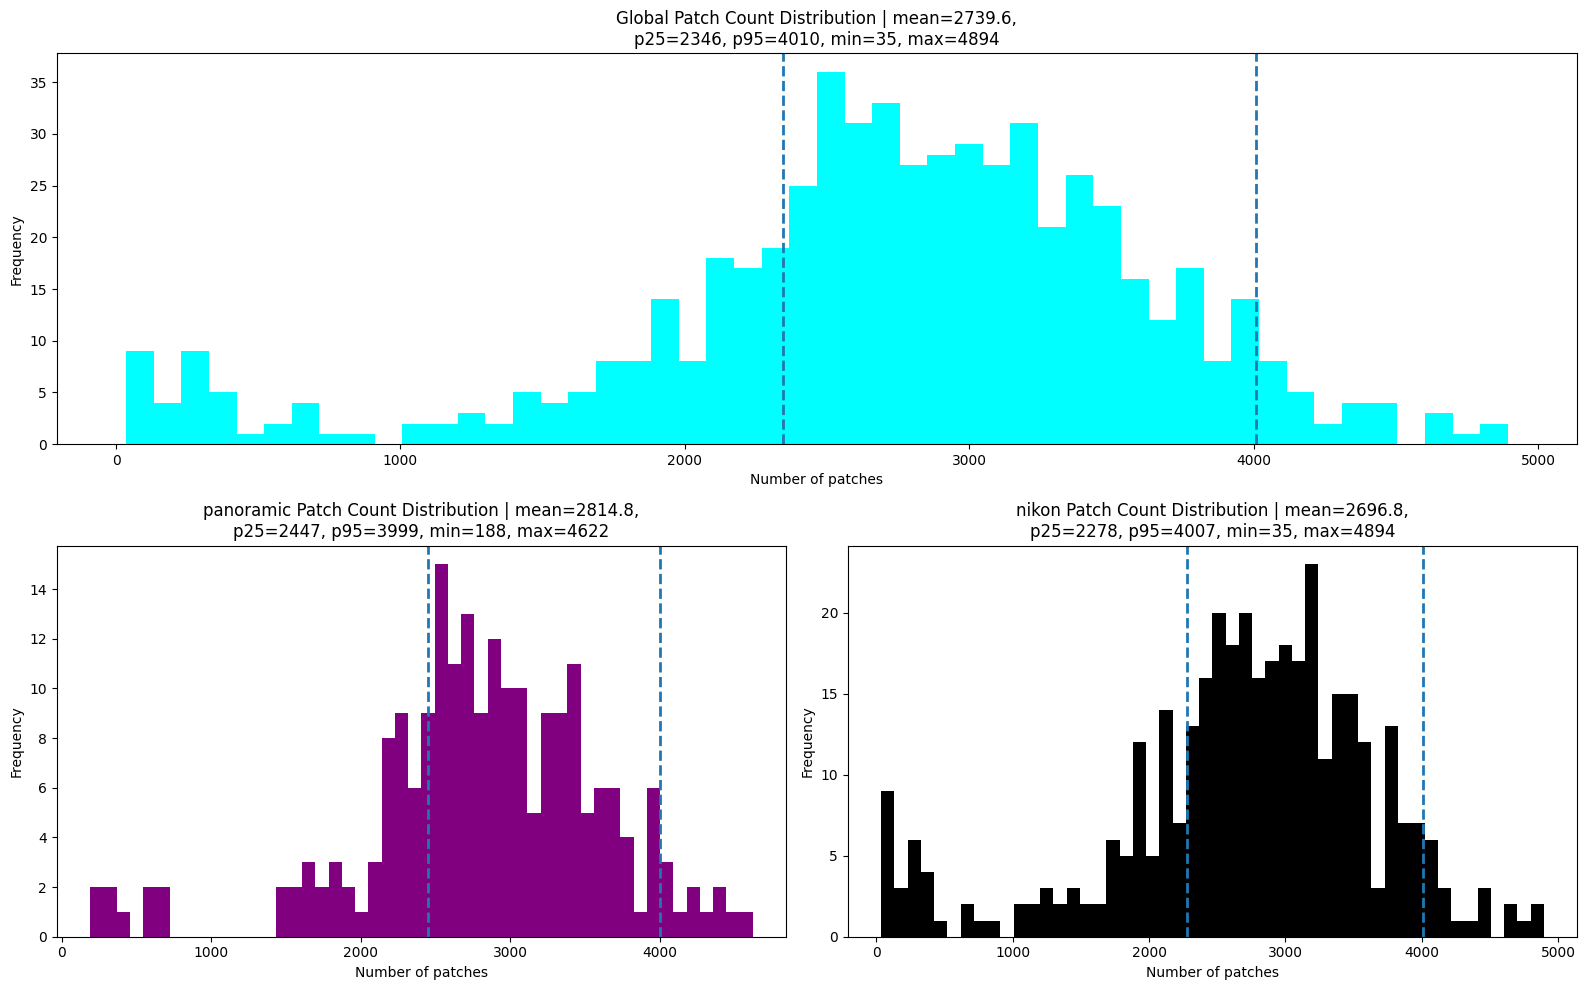

In [ ]:
global_counts = np.array(global_counts)

scanner_names = list(patch_counts.keys())
scanner1 = scanner_names[0]
scanner2 = scanner_names[1]

fig = plt.figure(figsize=(16, 10))

# --- Global plot ---
ax1 = plt.subplot2grid((2, 1), (0, 0))
ax1.hist(global_counts, bins=50, color="cyan")
add_percentiles(ax1, global_counts)
ax1.set_title(metric_title("Global Patch Count Distribution", global_counts))
ax1.set_xlabel("Number of patches")
ax1.set_ylabel("Frequency")

# --- Scanner 1 ---
ax2 = plt.subplot2grid((2, 2), (1, 0))
vals1 = np.array(patch_counts[scanner1])
ax2.hist(vals1, bins=50, color="purple")
add_percentiles(ax2, vals1)
ax2.set_title(metric_title(f"{scanner1} Patch Count Distribution", vals1))
ax2.set_xlabel("Number of patches")
ax2.set_ylabel("Frequency")

# --- Scanner 2 ---
ax3 = plt.subplot2grid((2, 2), (1, 1))
vals2 = np.array(patch_counts[scanner2])
ax3.hist(vals2, bins=50, color="black")
add_percentiles(ax3, vals2)
ax3.set_title(metric_title(f"{scanner2} Patch Count Distribution", vals2))
ax3.set_xlabel("Number of patches")
ax3.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Accellerating tiling

## Target slowness cause

1. Opening the image at maximum maginification $n$ times; 
2. Opening at an (unnecessary) higher level;

In [ ]:
# Load an image @ max magnification
tile_size_microns = 360
wsi_res = float(max(wsi.properties['openslide.mpp-x'],wsi.properties['openslide.mpp-y']))
n_pixel_in_level_0 = tile_size_microns / wsi_res
n_pixel_resized = 224
downsamle_factor = n_pixel_in_level_0 / n_pixel_resized
n_pixel_in_level_0_norm = int(np.ceil(n_pixel_in_level_0))
print(f"{tile_size_microns}μm at resolution {wsi_res:.2f}μm/px need {n_pixel_in_level_0_norm} px")
print(f"Downsample factor due to resampling to {n_pixel_resized} px = {downsamle_factor:.2f}")

360μm at resolution 0.22μm/px need 1629 px
Downsample factor due to resampling to 224 px = 7.27


In [25]:
wsi.level_downsamples

(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0)

In [58]:
target_resolution = tile_size_microns / n_pixel_resized
resolutions = { i : scaling_factor * wsi_res for i, scaling_factor in enumerate(wsi.level_downsamples)}
print(f"Resolution after {n_pixel_in_level_0_norm}px --> {n_pixel_resized}px downsampling is {target_resolution}")

Resolution after 1629px --> 224px downsampling is 1.6071428571428572


In [59]:
from tabulate import tabulate

table = [(k, wsi.level_downsamples[k] , f"{v:.2f}") for k, v in resolutions.items()]
print(tabulate(table, headers=["Level", "Scaling Factor", "Resolution (μm/px)"], tablefmt="grid"))

+---------+------------------+----------------------+
|   Level |   Scaling Factor |   Resolution (μm/px) |
+=========+==================+======================+
|       0 |                1 |                 0.22 |
+---------+------------------+----------------------+
|       1 |                2 |                 0.44 |
+---------+------------------+----------------------+
|       2 |                4 |                 0.88 |
+---------+------------------+----------------------+
|       3 |                8 |                 1.77 |
+---------+------------------+----------------------+
|       4 |               16 |                 3.54 |
+---------+------------------+----------------------+
|       5 |               32 |                 7.07 |
+---------+------------------+----------------------+
|       6 |               64 |                14.14 |
+---------+------------------+----------------------+
|       7 |              128 |                28.29 |
+---------+-----------------

In [62]:
tiling_level = wsi.get_best_level_for_downsample(downsamle_factor)
print(f"At level {tiling_level}, WSI's resolution is {resolutions[tiling_level]:.2f} μm/px")

At level 2, WSI's resolution is 0.88 μm/px


In [161]:
from preprocess import crop_rect_from_slide
import openslide
from shapely.geometry import Polygon

def compute_scaling_factor(wsi, tile_size_microns : float , n_pixel_resized : int ):
    mpp_x = float(wsi.properties['openslide.mpp-x'])
    mpp_y = float(wsi.properties['openslide.mpp-y'])

    wsi_res = max(mpp_x, mpp_y)
    n_pixel_in_level_0 = tile_size_microns / wsi_res

    downsample_factor = n_pixel_in_level_0 / n_pixel_resized
    return downsample_factor

def crop_rect_from_slide_at_level(slide : openslide.OpenSlide, rect : Polygon, level : int):
    minx, miny, maxx, maxy = rect.bounds
    scaling_factor = slide.level_downsamples[level]
    x,y = int(minx), int(miny)
    w,h = int((maxx - minx) / scaling_factor), int((maxy - miny) / scaling_factor)
    img = slide.read_region((x, y), level, (w, h))
    return img

patch_counts = defaultdict(list)  
global_counts = []
error_rows = []

n_example = 3
RGB_threshold = 20 

# --- DOWNSAMPLED LOOP ---

if QC_DIR is not None: 
    generate_quality_check_image(
        wsi=wsi,
        slide_id=slide_id,
        seg_level = seg_level,
        tiles = tiles,
        sampled_tiles = tiles,
        save_dir = QC_DIR 
    )

scaling_factor = compute_scaling_factor(wsi,
                    tile_size_microns=tile_size_microns,
                    n_pixel_resized=out_size)
opening_level = wsi.get_best_level_for_downsample(scaling_factor)

sub_dir = f"/read_from_{opening_level}_level"
_slide_dir = slide_dir + sub_dir
os.makedirs(_slide_dir,exist_ok=True)

for i, tile in tqdm(enumerate(tiles[:n_example]),
                    desc = f"Reading and Saving {slide_id} tiles",
                    total = len(tiles[:n_example])): 
    
    print(tile)
    img = crop_rect_from_slide_at_level(wsi, tile, level = opening_level)

    # # RGB Thresholding
    if not tile_is_not_empty(img, threshold_white=RGB_threshold) :
        print("EMPTY")
        # continue

    width, height = img.size
    assert width == height, "input image is not a square"

    img = img.resize((out_size, out_size))

    # Convert from RGBA to RGB (don't care about the alpha channel anyway)
    img = img.convert("RGB")

    out_file = os.path.join(_slide_dir, f"{row['wsi_id']}_tile_{i}.png")
    img.save(out_file, format="png", quality=100, subsampling=0)


Reading and Saving 22 B 07247 D1 tiles: 100%|██████████| 3/3 [00:00<00:00, 39.16it/s]

POLYGON ((7523 24482, 9152 24482, 9152 22853, 7523 22853, 7523 24482))
POLYGON ((9152 24482, 10781 24482, 10781 22853, 9152 22853, 9152 24482))
POLYGON ((9152 26111, 10781 26111, 10781 24482, 9152 24482, 9152 26111))


## Benchmarking

In [175]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import ttest_rel

# ---------------- CONFIG ----------------
tile_size_microns = 360
n_pixel_resized = out_size
levels_to_test = [0, 1, 2, 3, 4]
n_test_tiles = 32

timing_dir = os.path.join(output_dir, "TIMING_PER_LEVEL")
os.makedirs(timing_dir, exist_ok=True)

tiles_to_test = tiles[:n_test_tiles]

# dizionario: tile_index -> {level_0: time, level_1: time, ...}
tile_times = {i: {} for i in range(len(tiles_to_test))}

# ---------------- LOOP PER LEVEL ----------------
for level in levels_to_test:
    level_dir = os.path.join(timing_dir, f"level_{level}")
    os.makedirs(level_dir, exist_ok=True)

    print(f"\n--- Benchmark level {level} ---")

    for i, tile in tqdm(enumerate(tiles_to_test), total=len(tiles_to_test)):

        start = time.time()
        img = crop_rect_from_slide_at_level(wsi, tile, level=level)

        is_not_empty = tile_is_not_empty(img, threshold_white=RGB_threshold)

        if is_not_empty:
            img = img.resize((n_pixel_resized, n_pixel_resized))
            img = img.convert("RGB")
            out_file = os.path.join(level_dir, f"tile_{i}.png")
            img.save(out_file, format="png", quality=100, subsampling=0)
            elapsed = time.time() - start
        else:
            elapsed = np.nan

        tile_times[i][f"level_{level} (s)"] = elapsed

# ---------------- SAVING RESULTS ----------------
df_tiles = pd.DataFrame.from_dict(tile_times, orient="index")
df_tiles.insert(0, "tile_index", df_tiles.index)
df_tiles.reset_index(drop=True, inplace=True)

excel_path = os.path.join(
    timing_dir, f"tile_timings_{tile_size_microns}um.xlsx"
)
df_tiles.to_excel(excel_path, index=False)

ttest_rows = []

for i, level in enumerate(levels_to_test):
    col_curr = f"level_{level} (s)"
    df_curr = df_tiles[col_curr].dropna()

    mean_time = df_curr.mean()
    std_time = df_curr.std()

    t_prev = p_prev = t_0 = p_0 = np.nan

    # --- vs previous level ---
    if i > 0:
        col_prev = f"level_{levels_to_test[i-1]} (s)"
        df_prev = df_tiles[col_prev].dropna()
        min_len = min(len(df_prev), len(df_curr))

        if min_len > 1:
            t_prev, p_prev = ttest_rel(
                df_prev.values[:min_len],
                df_curr.values[:min_len],
                alternative="greater"  # H0: current not slower than previous
            )

    # --- vs level 0 ---
    if i > 0:
        col_0 = f"level_0 (s)"
        df_0 = df_tiles[col_0].dropna()
        min_len = min(len(df_0), len(df_curr))

        if min_len > 1:
            t_0, p_0 = ttest_rel(
                df_0.values[:min_len],
                df_curr.values[:min_len],
                alternative="greater"
            )

    ttest_rows.append({
        "level": level,
        "mean_time": mean_time,
        "std_time": std_time,
        "t_stat_vs_prev": t_prev,
        "p_value_vs_prev": p_prev,
        "t_stat_vs_level0": t_0,
        "p_value_vs_level0": p_0
    })

# --- CREA DATAFRAME E SALVA ---
df_ttest = pd.DataFrame(ttest_rows)

ttest_excel_path = os.path.join(
    timing_dir, f"ttest_results_{tile_size_microns}um.xlsx"
)
df_ttest.to_excel(ttest_excel_path, index=False)

print("T-test results saved to:", ttest_excel_path)

# ---------------- BOXPLOT ----------------

data_per_level = []
x_labels = []
resolutions = []

# compute resolutions for each level
mpp_x = float(wsi.properties['openslide.mpp-x'])
mpp_y = float(wsi.properties['openslide.mpp-y'])
wsi_res = max(mpp_x, mpp_y)  # μm/px at level 0

for level in levels_to_test:
    col = f"level_{level} (s)"
    data_per_level.append(df_tiles[col].dropna().values)

    downsample_factor = wsi.level_downsamples[level]
    res_at_level = wsi_res * downsample_factor
    resolutions.append(res_at_level)

    x_labels.append(f"Level {level}\n{res_at_level:.2f} μm/px")

plt.figure(figsize=(10, 6))

plt.boxplot(
    data_per_level,
    widths=0.6,
    showfliers=True,
    medianprops=dict(color="green", linewidth=2)
)

plt.xlabel("Downsample level and resolution")
plt.ylabel("Time per tile (s)")
plt.title(f"Reading Time (tile size = {tile_size_microns} μm, output size = {out_size}x{out_size}, res = {(tile_size_microns/out_size):.2f} μm/px)")

# Grid (vertical dashed lines)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.xticks(range(1, len(x_labels) + 1), x_labels)

plt.tight_layout()

plt.savefig(os.path.join(
    timing_dir,
    f"timing_distribution_{tile_size_microns}um.png"
))
plt.close()


--- Benchmark level 0 ---


100%|██████████| 32/32 [00:08<00:00,  3.69it/s]



--- Benchmark level 1 ---


100%|██████████| 32/32 [00:05<00:00,  6.37it/s]



--- Benchmark level 2 ---


100%|██████████| 32/32 [00:01<00:00, 21.29it/s]



--- Benchmark level 3 ---


100%|██████████| 32/32 [00:00<00:00, 40.74it/s]



--- Benchmark level 4 ---


100%|██████████| 32/32 [00:00<00:00, 70.79it/s]


T-test results saved to: _jupyter_tests/TIMING_PER_LEVEL\ttest_results_360um.xlsx


## TRIDENT

In [ ]:
wsi.level_dimensions[1]

In [ ]:
# Risoluzione in micron/pixel a livello 0
mpp_x = float(wsi.properties['openslide.mpp-x'])
mpp_y = float(wsi.properties['openslide.mpp-y'])
mpp_x == mpp_y

In [ ]:
mpp_x * wsi.level_downsamples[1]

In [ ]:
patch_size_trident = 256
mpp_x * wsi.level_downsamples[1] * patch_size_trident